In [7]:
import requests
import csv
import json
import numpy as np
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt

In [8]:

################ CACHING & DATA RETRIEVAL ###################
# -----------------------------------------------------------------------------
# Constants
# -----------------------------------------------------------------------------
CACHE_FNAME = 'cache_file.json'
DATETIME_FORMAT = "%Y-%m-%d %H:%M:%S.%f"
DEBUG = False
# MAKE SURE TO DROP TABLE EVEN WITHOUT DEBUG, BEFORE YOU RERUN IT


# -----------------------------------------------------------------------------
# Load cache file
# -----------------------------------------------------------------------------
try:
    with open(CACHE_FNAME, 'r') as cache_file:
        cache_json = cache_file.read()
        CACHE_DICTION = json.loads(cache_json)
except:
    CACHE_DICTION = {}


# CITE: Anand Doshi, nytimes.py
def has_cache_expired(timestamp_str, expire_in_days): # BUG 1
    """Check if cache timestamp is over expire_in_days old"""
    # gives current datetime
    now = datetime.now()

    # datetime.strptime converts a formatted string into datetime object
    cache_timestamp = datetime.strptime(timestamp_str, DATETIME_FORMAT)

    # subtracting two datetime objects gives you a timedelta object
    delta = now - cache_timestamp
    delta_in_days = delta.days

    # now that we have days as integers, we can just use comparison
    # and decide if cache has expired or not
    if delta_in_days < expire_in_days: #BUG 2
        return False
    else:
        return True

# CITE: Jackie Cohen, Runestone Virtual Textbook
def params_unique_combination(baseurl, params_d, private_keys=["api_key"]):
    alphabetized_keys = sorted(params_d.keys())
    res = []
    for k in alphabetized_keys:
        if k not in private_keys:
            res.append("{}-{}".format(k, params_d[k]))
    return baseurl + "_".join(res)

# CITE: Anand Doshi, nytimes.py
def get_from_cache(url, params_d):
    """If URL exists in cache and has not expired, return the html, else return None"""
    cache_key = params_unique_combination(url, params_d)
    if cache_key in CACHE_DICTION:
        url_dict = CACHE_DICTION[cache_key]
 #       html = CACHE_DICTION[url]['html']
        if has_cache_expired(url_dict['timestamp'], url_dict['expire_in_days']):
            # also remove old copy from cache
            del CACHE_DICTION[cache_key]
            html = None
        else:
            html = CACHE_DICTION[cache_key]['html']
    else:
        html = None

    return html

# CITE: Anand Doshi, nytimes.py
def set_in_cache(url, params_d, html, expire_in_days):
    """Add URL and html to the cache dictionary, and save the whole dictionary to a file as json"""
    cache_key = params_unique_combination(url, params_d)
    
    CACHE_DICTION[cache_key] = {
        'html': html,
        'timestamp': datetime.now().strftime(DATETIME_FORMAT),
        'expire_in_days': expire_in_days
    }

    with open(CACHE_FNAME, 'w') as cache_file:
        cache_json = json.dumps(CACHE_DICTION)
        cache_file.write(cache_json)

# CITE: Anand Doshi, nytimes.py
def get_html_from_url(url, params_d, expire_in_days=7): #Added params_d
    """Check in cache, if not found, load html, save in cache and then return that html"""
    # check in cache
    html = get_from_cache(url, params_d)
 #   print(html)
    if html is not None:
        if DEBUG:
            print('Loading from cache: {0}'.format(url))
    else:
 #       if DEBUG:
        print('Fetching a fresh copy: {0}'.format(url))
 #       print()

        # fetch fresh
        response = requests.get(url, params=params_d)

        # Deleted line about encoding because it was messing up my shit

        html = response.text

        # cache it
        set_in_cache(url, params_d, html, expire_in_days)

    return html

def search_google_scholar(search_term, params_d = {}):
	baseurl = "https://scholar.google.com/scholar"
	params_d['q'] = search_term
	
	google_results = get_html_from_url(baseurl, params_d, expire_in_days=1)
	google_soup = BeautifulSoup(google_results, 'html.parser')

	#return soup.prettify()

	# returns list of paper htmls for processing by class Paper
	return google_soup.find_all('div',{'class':'gs_r gs_or gs_scl'})


######################## END CACHING #############################################

In [9]:
apiKey = "HMWB7P32VDNFFUKMJ98YAGYBG1ERGXQG45"

In [10]:
def RequestWalletAddress(address):
    #contractAddress = '0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2'
    params_d = {}
    baseurl = "https://api.etherscan.io/api"
    params_d['module'] = "account"
    params_d['action'] = "tokentx"
    params_d['contractaddress'] = '0xdac17f958d2ee523a2206206994597c13d831ec7' # tether
    params_d['address'] = address
    #params_d['offset'] = 100
    params_d['sort'] = "asc"
    params_d['apikey'] = apiKey
    
    google_results = get_html_from_url(baseurl, params_d, expire_in_days=1)
    #print(google_results)
    results = json.loads(google_results)['result']
    
    return results

In [19]:
def ResultScan(results):
    outAddress = {} # who are they submitting to
    inAddress = {} # who is sending to them
    
    for transaction in results:
        if transaction['from'].upper() == address.upper(): # outgoing transactions
            if transaction['to'] not in outAddress:
                outAddress[transaction['to']] = 0
            outAddress[transaction['to']] = outAddress[transaction['to']] + 1
        if transaction['to'].upper () == address.upper(): # incoming transactions
            if transaction['from'] not in inAddress:
                inAddress[transaction['from']] = 0
            inAddress[transaction['from']] = inAddress[transaction['from']] + 1
    
    return outAddress, inAddress

In [62]:
origAddress = '0x237a2817A7a100Fcc6FFF4550eC3AEf99a4Ce811'
addressList = [origAddress]
G = nx.DiGraph()
maxAddress = []
bigNodes = []

for iter in range(10): # go in 5 levels
    maxAddress + addressList
    
    for address in addressList:
        # get results
        results = RequestWalletAddress(address)
        outAddress, inAddress = ResultScan(results)

        # Graph outgoing transfers
        total = np.sum([outAddress[x] for x in outAddress])
        for to_add in outAddress:
            numTransactions = outAddress[to_add]
            wt = numTransactions/total
            if numTransactions > 50:
                bigNodes.append(to_add)
            if wt > 0.01: # exchange is > 1% of all trades
                G.add_edge(address[-4:], to_add[-4:], weight=wt)
    
    idxMaxAddresses = np.array([outAddress[x] for x in outAddress]).argsort()[-3:][::-1]
    addressList = [list(outAddress)[x] for x in idxMaxAddresses]
    
    for address in addressList:
        if address in maxAddress:
            addressList.pop(addressList.index(address))

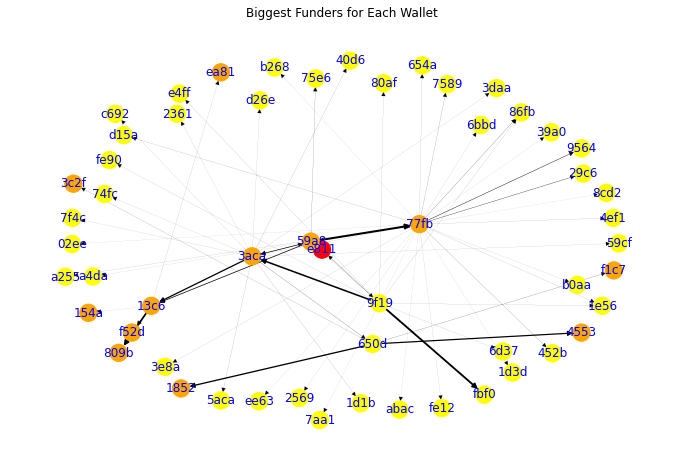

In [63]:
color_map = []
bigNodes = [x[-4:] for x in bigNodes]
for node in G:
    if node == origAddress[-4:]:
        color_map.append('red')
    elif node in bigNodes: 
        color_map.append('orange')
    else:
        color_map.append('yellow')

fig = plt.subplots(figsize=(12,8))
edges = G.edges()
weights = [G[u][v]['weight']*4 for u,v in edges]
nx.draw(G, with_labels=True, width=weights, arrows=True, node_color=color_map,font_color="blue")
plt.title('Biggest Funders for Each Wallet')
plt.savefig('BiggestFunders.png')
plt.show()

# Check Receiving

In [99]:
origAddress = '0x56a674557f3aaaafcff295e1680087b6c46359a8'
addressList = [origAddress]
G = nx.DiGraph()
maxAddress = []
bigNodes = []
totalTransactions = {}

for iter in range(5): # go in 5 levels
    maxAddress + addressList
    
    for address in addressList:
        # get results
        results = RequestWalletAddress(address)
        outAddress, inAddress = ResultScan(results)
        if address not in totalTransactions:
            totalTransactions[address[-4:]] = np.sum([inAddress[x] for x in inAddress])

        # Graph outgoing transfers
        total = np.sum([inAddress[x] for x in inAddress])
        for to_add in inAddress:
            numTransactions = inAddress[to_add]
            wt = numTransactions / total
            if numTransactions > 100:
                bigNodes.append(to_add)
            if wt > 0.01: # exchange is > 1% of all trades
                G.add_edge(address[-4:], to_add[-4:], weight=wt)
    
    idxMaxAddresses = np.array([inAddress[x] for x in inAddress]).argsort()[-5:][::-1]
    addressList = [list(inAddress)[x] for x in idxMaxAddresses]
    
    for address in addressList:
        if address in maxAddress:
            addressList.pop(addressList.index(address))

In [100]:
import seaborn as sns

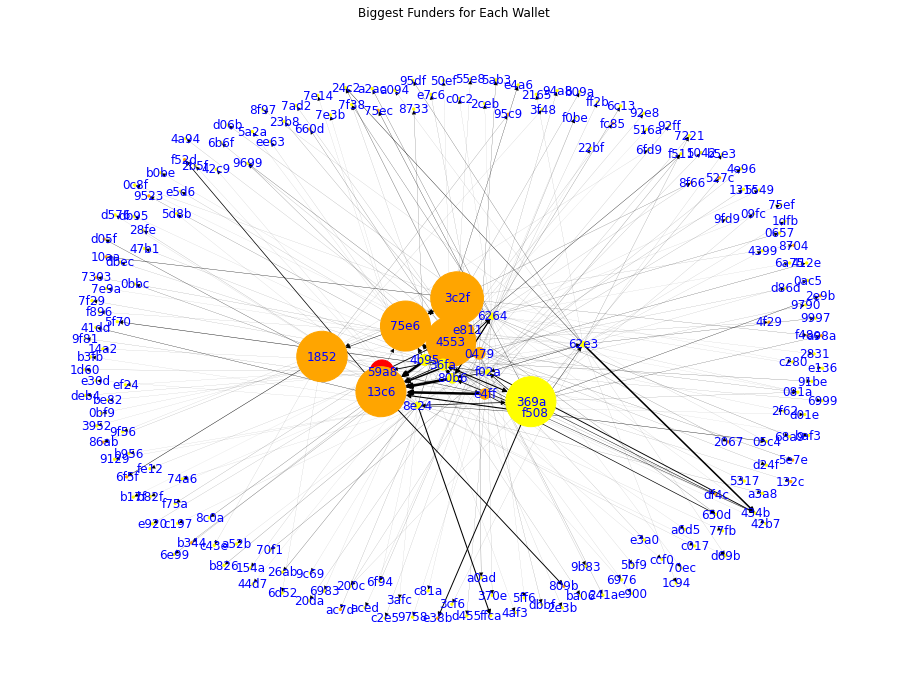

In [101]:
color_map = []
bigNodes = [x[-4:] for x in bigNodes]
nodeSize = []
for node in G:
    if node == origAddress[-4:]:
        color_map.append('red')
    elif node in bigNodes: 
        color_map.append('orange')
    else:
        color_map.append('yellow')
    
    if node in totalTransactions:
        nodeSize.append(int(totalTransactions[node]/2)) # only the investigated nodes will have a size
    else:
        nodeSize.append(5) 
    

fig = plt.subplots(figsize=(16,12))
edges = G.edges()
weights = [G[u][v]['weight']*4 for u,v in edges]
nx.draw(G, with_labels=True, width=weights, arrows=True, node_color=color_map,font_color="blue",node_size=nodeSize)
plt.title('Biggest Funders for Each Wallet')
plt.savefig('BiggestFunders.png')
plt.show()

In [103]:
!pip install pygraphviz

     |████████████████████████████████| 118 kB 3.5 MB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /Users/elisawarner/opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/9n/gb509k017vq7ts_p5pp1kp7w0000gn/T/pip-install-1d8c80t0/pygraphviz_df90513c4f3c4b3a9269c0dba89a05f5/setup.py'"'"'; __file__='"'"'/private/var/folders/9n/gb509k017vq7ts_p5pp1kp7w0000gn/T/pip-install-1d8c80t0/pygraphviz_df90513c4f3c4b3a9269c0dba89a05f5/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/9n/gb509k017vq7ts_p5pp1kp7w0000gn/T/pip-wheel-9syd18vb
       cwd: /private/var/folders/9n/gb509k017vq7ts_p5pp1kp7w0000gn/T/pip-install-1d8c80t0/pygraphviz_df90513c4f3c4b3a9269c0dba89a05f5/
  Complete output (53 lines):
  running bdist_wheel
  running build
  running build_py
  crea

In [102]:
impor
pos = nx.nx_agraph.graphviz_layout(G, prog="neato")

ImportError: requires pygraphviz http://pygraphviz.github.io/